<a href="https://colab.research.google.com/github/antonsysoev/comp_tech2025/blob/main/Lecture_12_Recommend_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Практический пример рекомендательной системы на R с SVD и матричной факторизацией
# Используем данные MovieLens 100k

# Установка и загрузка необходимых пакетов
if (!require(recommenderlab)) install.packages("recommenderlab")
if (!require(ggplot2)) install.packages("ggplot2")
if (!require(dplyr)) install.packages("dplyr")
if (!require(kernlab)) install.packages("kernlab")
if (!require(Matrix)) install.packages("Matrix")

library(recommenderlab)
library(ggplot2)
library(dplyr)
library(kernlab)
library(Matrix)

Loading required package: recommenderlab

Loading required package: Matrix

Loading required package: arules


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy

Loading required package: ggplot2

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:arules’:

    intersect, recode, setdiff, setequal, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequ

Загрузка данных MovieLens 100k...
Информация о датасете:
Количество пользователей: 943 
Количество фильмов: 1664 
Количество оценок: 99392 
Разреженность: 93.67 %

Распределение оценок:
  rating     n percentage
1      1  6059   6.096064
2      2 11307  11.376167
3      3 27002  27.167176
4      4 33947  34.154660
5      5 21077  21.205932

Разделение данных:
Обучающая выборка: 754 пользователей
Тестовая выборка: 189 пользователей


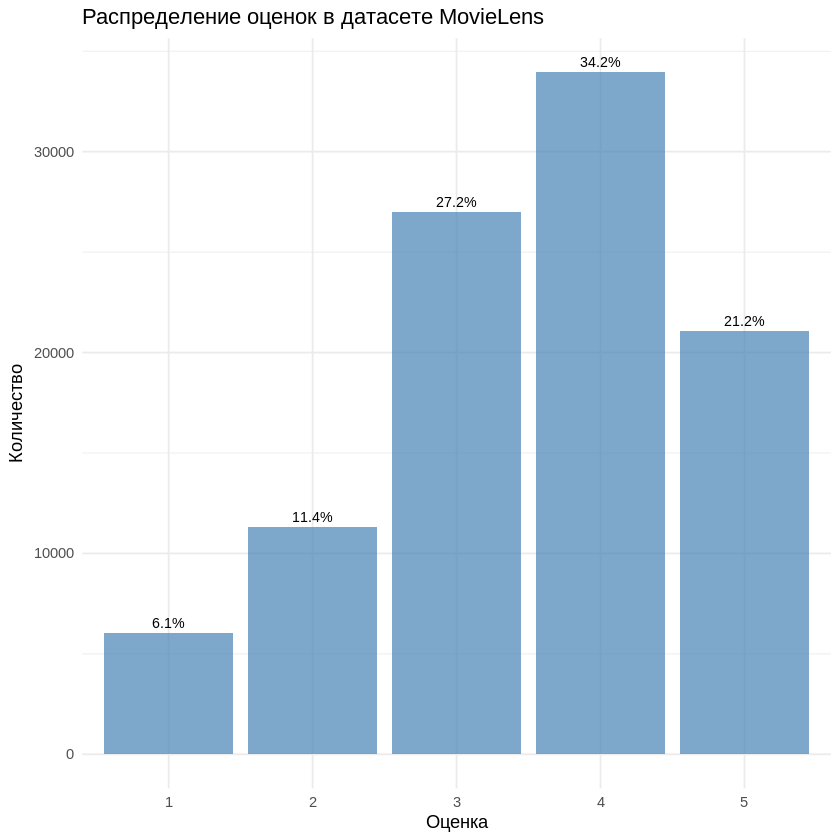

In [2]:
# Загрузка данных MovieLens 100k
cat("Загрузка данных MovieLens 100k...\n")
data(MovieLense)
ratings_data <- MovieLense

# Основная информация о данных
cat("Информация о датасете:\n")
cat("Количество пользователей:", nrow(ratings_data), "\n")
cat("Количество фильмов:", ncol(ratings_data), "\n")
cat("Количество оценок:", sum(as.vector(!is.na(as(ratings_data, "matrix")))), "\n")
cat("Разреженность:", round((1 - (sum(as.vector(!is.na(as(ratings_data, "matrix")))) /
                                   (nrow(ratings_data) * ncol(ratings_data)))) * 100, 2), "%\n")

# Визуализация распределения оценок
ratings_vector <- as.vector(ratings_data@data)
ratings_vector <- ratings_vector[ratings_vector != 0]

rating_dist <- data.frame(rating = ratings_vector) %>%
  count(rating) %>%
  mutate(percentage = n / sum(n) * 100)

cat("\nРаспределение оценок:\n")
print(rating_dist)

ggplot(rating_dist, aes(x = factor(rating), y = n)) +
  geom_bar(stat = "identity", fill = "steelblue", alpha = 0.7) +
  geom_text(aes(label = paste0(round(percentage, 1), "%")),
            vjust = -0.5, size = 3) +
  labs(title = "Распределение оценок в датасете MovieLens",
       x = "Оценка", y = "Количество") +
  theme_minimal()

# Разделение данных на обучающую и тестовую выборки
set.seed(123)
eval_sets <- evaluationScheme(ratings_data,
                             method = "split",
                             train = 0.8,
                             given = 10,
                             goodRating = 4)

cat("\nРазделение данных:\n")
cat("Обучающая выборка:", nrow(getData(eval_sets, "train")), "пользователей\n")
cat("Тестовая выборка:", nrow(getData(eval_sets, "unknown")), "пользователей\n")

In [3]:
# SVD
cat("\n=== SVD ===\n")

svd_model <- Recommender(getData(eval_sets, "train"), "SVD",
                        param = list(k = 50, maxiter = 100))

# Предсказания и оценка
svd_predictions <- predict(svd_model, getData(eval_sets, "known"), type = "ratings")
svd_accuracy <- calcPredictionAccuracy(svd_predictions, getData(eval_sets, "unknown"))

cat("Точность SVD модели:\n")
cat("RMSE:", round(svd_accuracy["RMSE"], 4), "\n")
cat("MSE:", round(svd_accuracy["MSE"], 4), "\n")
cat("MAE:", round(svd_accuracy["MAE"], 4), "\n")


=== SVD ===
Точность SVD модели:
RMSE: 1.016 
MSE: 1.0322 
MAE: 0.7957 


In [4]:
# МАТРИЧНАЯ ФАКТОРИЗАЦИЯ С РЕГУЛЯРИЗАЦИЕЙ
cat("\n=== МАТРИЧНАЯ ФАКТОРИЗАЦИЯ ===\n")

# Реализация матричной факторизации с регуляризацией
matrix_factorization <- function(R, k = 50, lambda = 0.1, learning_rate = 0.001,
                                iterations = 100, verbose = TRUE) {

  # Инициализация матриц P и Q
  m <- nrow(R)
  n <- ncol(R)
  P <- matrix(rnorm(m * k, mean = 0, sd = 0.1), nrow = m, ncol = k)
  Q <- matrix(rnorm(n * k, mean = 0, sd = 0.1), nrow = n, ncol = k)

  # Смещения пользователей и предметов
  b_u <- rep(0, m)
  b_i <- rep(0, n)
  mu <- mean(R[R != 0], na.rm = TRUE)

  # Индексы известных оценок
  known_ratings <- which(!is.na(R) & R != 0, arr.ind = TRUE)

  # Градиентный спуск
  for (iter in 1:iterations) {
    total_error <- 0
    count <- 0

    # Случайное перемешивание данных
    shuffled_indices <- sample(1:nrow(known_ratings))

    for (idx in shuffled_indices) {
      i <- known_ratings[idx, 1]
      j <- known_ratings[idx, 2]
      r_ij <- R[i, j]

      # Предсказание с учетом смещений
      prediction <- mu + b_u[i] + b_i[j] + sum(P[i, ] * Q[j, ])
      error <- r_ij - prediction

      # Обновление параметров
      b_u[i] <- b_u[i] + learning_rate * (error - lambda * b_u[i])
      b_i[j] <- b_i[j] + learning_rate * (error - lambda * b_i[j])

      for (f in 1:k) {
        P[i, f] <- P[i, f] + learning_rate * (error * Q[j, f] - lambda * P[i, f])
        Q[j, f] <- Q[j, f] + learning_rate * (error * P[i, f] - lambda * Q[j, f])
      }

      total_error <- total_error + error^2
      count <- count + 1
    }

    if (verbose && iter %% 20 == 0) {
      cat("Итерация", iter, "Ошибка:", round(sqrt(total_error/count), 4), "\n")
    }
  }

  return(list(P = P, Q = Q, b_u = b_u, b_i = b_i, mu = mu))
}

# Применение матричной факторизации к нашим данным
train_matrix <- as(getData(eval_sets, "train"), "matrix")
mf_result <- matrix_factorization(train_matrix, k = 50, lambda = 0.01,
                                 learning_rate = 0.001, iterations = 100)

# Функция для предсказания оценок
predict_mf <- function(mf_model, test_data) {
  test_matrix <- as(test_data, "matrix")
  predictions <- matrix(NA, nrow = nrow(test_matrix), ncol = ncol(test_matrix))

  # Получаем все возможные пользователь-предмет пары
  # (для реального применения можно ограничиться только теми, что нужны)
  for (i in 1:nrow(test_matrix)) {
    for (j in 1:ncol(test_matrix)) {
      # Предсказываем для всех пар, а не только для тех, где уже есть оценки
      predictions[i, j] <- mf_model$mu + mf_model$b_u[i] + mf_model$b_i[j] +
        sum(mf_model$P[i, ] * mf_model$Q[j, ])
      # Ограничиваем предсказания диапазоном 1-5
      predictions[i, j] <- max(1, min(5, predictions[i, j]))
    }
  }

  # Но при этом маскируем те оценки, которые уже известны в тестовых данных
  # (чтобы не учитывать их при оценке)
  predictions[!is.na(test_matrix) & test_matrix != 0] <- NA

  return(as(predictions, "realRatingMatrix"))
}

# Оценка матричной факторизации
mf_predictions <- predict_mf(mf_result, getData(eval_sets, "known"))
mf_accuracy <- calcPredictionAccuracy(mf_predictions, getData(eval_sets, "unknown"), given = 0)

cat("Точность матричной факторизации:\n")
cat("RMSE:", round(mf_accuracy["RMSE"], 4), "\n")
cat("MSE:", round(mf_accuracy["MSE"], 4), "\n")
cat("MAE:", round(mf_accuracy["MAE"], 4), "\n")


=== МАТРИЧНАЯ ФАКТОРИЗАЦИЯ ===
Итерация 20 Ошибка: 0.9298 
Итерация 40 Ошибка: 0.8931 
Итерация 60 Ошибка: 0.8534 
Итерация 80 Ошибка: 0.8005 
Итерация 100 Ошибка: 0.7414 
Точность матричной факторизации:
RMSE: 1.0958 
MSE: 1.2009 
MAE: 0.8784 


In [5]:
install.packages("FNN")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
# SVD С ГАУССОВСКИМ ЯДРОМ (ОПТИМИЗИРОВАННЫЙ)
cat("\n=== SVD С ГАУССОВСКИМ ЯДРОМ (ОПТИМИЗИРОВАННЫЙ) ===\n")

kernel_svd_optimized <- function(R, k = 10, gamma = 0.5, lambda = 0.01,
                                 iterations = 10, learning_rate = 0.01,
                                 batch_size = 2000, n_neighbors = 20) {

  # Преобразуем матрицу
  R_matrix <- as(R, "matrix")
  known_indices <- which(!is.na(R_matrix) & R_matrix != 0, arr.ind = TRUE)

  m <- nrow(R_matrix)
  n <- ncol(R_matrix)

  # Проверка на наличие данных
  if (nrow(known_indices) == 0) {
    stop("Нет известных рейтингов в данных")
  }

  # Инициализация латентных векторов с меньшей дисперсией
  set.seed(123)
  U <- matrix(rnorm(m * k, sd = 0.01), nrow = m, ncol = k)
  V <- matrix(rnorm(n * k, sd = 0.01), nrow = n, ncol = k)

  cat("Инициализация случайных соседей...\n")

  # Используем случайных соседей вместо KNN для ускорения
  set.seed(123)
  neighbor_list <- vector("list", m)
  for (i in 1:m) {
    neighbor_list[[i]] <- sample(setdiff(1:m, i), min(n_neighbors, m-1))
  }

  # Функция для быстрого вычисления ядерных весов
  compute_kernel_weights <- function(i, neighbors, U, gamma) {
    if (length(neighbors) == 0) return(numeric(0))

    # Векторизованное вычисление расстояний
    dist_sq <- rowSums((U[rep(i, length(neighbors)), , drop = FALSE] -
                         U[neighbors, , drop = FALSE])^2)
    exp(-gamma * dist_sq)
  }

  # Обучение с мини-пакетами
  n_samples <- nrow(known_indices)

  for (iter in 1:iterations) {
    start_time <- Sys.time()
    total_error <- 0

    # Случайный порядок для SGD
    shuffled_indices <- sample(n_samples)

    # Обработка мини-пакетами
    for (batch_start in seq(1, n_samples, by = batch_size)) {
      batch_end <- min(batch_start + batch_size - 1, n_samples)
      batch_idx <- shuffled_indices[batch_start:batch_end]

      # Векторизованные вычисления для батча
      for (idx in batch_idx) {
        i <- known_indices[idx, 1]
        j <- known_indices[idx, 2]

        # Проверка границ индексов
        if (i < 1 || i > m || j < 1 || j > n) next

        r_ij <- R_matrix[i, j]

        # Быстрое предсказание
        if (length(neighbor_list[[i]]) > 0) {
          neighbors <- neighbor_list[[i]]
          weights <- compute_kernel_weights(i, neighbors, U, gamma)

          if (length(weights) > 0 && sum(weights) > 1e-10) {
            neighbor_scores <- U[neighbors, , drop = FALSE] %*% V[j, ]
            prediction <- sum(weights * neighbor_scores) / sum(weights)
          } else {
            prediction <- U[i, ] %*% V[j, ]
          }
        } else {
          prediction <- U[i, ] %*% V[j, ]
        }

        error <- r_ij - prediction
        total_error <- total_error + error^2

        # Обновление латентных векторов
        grad_U_i <- error * V[j, ] - lambda * U[i, ]
        grad_V_j <- error * U[i, ] - lambda * V[j, ]

        U[i, ] <- U[i, ] + learning_rate * grad_U_i
        V[j, ] <- V[j, ] + learning_rate * grad_V_j
      }
    }

    # Обновляем список соседей каждые 3 итерации (упрощенное)
    if (iter %% 3 == 0 && m > 1 && iter < iterations) {
      cat("Обновление соседей...\n")
      # Используем случайных соседей для скорости
      for (i in 1:m) {
        neighbor_list[[i]] <- sample(setdiff(1:m, i), min(n_neighbors, m-1))
      }
    }

    rmse <- sqrt(total_error / n_samples)
    elapsed <- Sys.time() - start_time

    cat(sprintf("Итерация %d: RMSE = %.4f, время = %.1f сек\n",
                iter, rmse, as.numeric(elapsed)))

    # Адаптивное уменьшение learning rate
    if (iter %% 5 == 0) {
      learning_rate <- learning_rate * 0.9
      cat(sprintf("Новый learning rate: %.5f\n", learning_rate))
    }

    # Ранняя остановка если сошлось
    if (iter > 5 && rmse < 0.9) {
      cat(sprintf("Ранняя остановка на итерации %d (RMSE < 0.9)\n", iter))
      break
    }
  }

  return(list(U = U, V = V, neighbors = neighbor_list))
}

# Функция для быстрого предсказания
predict_kernel_svd_optimized <- function(model, test_data) {
  R_test <- as(test_data, "matrix")
  test_indices <- which(!is.na(R_test) & R_test != 0, arr.ind = TRUE)

  m <- nrow(R_test)
  n <- ncol(R_test)
  k <- ncol(model$U)

  cat(sprintf("Предсказание для %d оценок...\n", nrow(test_indices)))

  predictions <- numeric(nrow(test_indices))

  # Используем батчи для предсказания
  batch_size <- 5000
  n_batches <- ceiling(nrow(test_indices) / batch_size)

  for (batch in 1:n_batches) {
    start_idx <- (batch - 1) * batch_size + 1
    end_idx <- min(batch * batch_size, nrow(test_indices))
    batch_indices <- test_indices[start_idx:end_idx, , drop = FALSE]

    for (idx in 1:nrow(batch_indices)) {
      i <- batch_indices[idx, 1]
      j <- batch_indices[idx, 2]

      # Упрощенное предсказание для скорости
      prediction <- sum(model$U[i, ] * model$V[j, ])

      # Ограничиваем значения
      prediction <- max(1, min(5, prediction))
      predictions[start_idx + idx - 1] <- prediction
    }

    if (batch %% 5 == 0) {
      cat(sprintf("  Обработано %d/%d батчей\n", batch, n_batches))
    }
  }

  return(predictions)
}

# Использование оптимизированных функций
cat("Обучение оптимизированного SVD с гауссовским ядром...\n")

# Уменьшаем параметры для скорости
kernel_result_opt <- kernel_svd_optimized(
  getData(eval_sets, "train"),
  k = 10,           # Уменьшено с 30
  gamma = 0.5,
  lambda = 0.01,
  iterations = 10,  # Уменьшено с 50
  learning_rate = 0.01,
  batch_size = 2000,
  n_neighbors = 15  # Уменьшено число соседей
)

# Оценка
cat("Выполнение предсказаний...\n")
kernel_predictions_opt <- predict_kernel_svd_optimized(
  kernel_result_opt,
  getData(eval_sets, "known")
)

# Получаем реальные оценки для проверки
actual_ratings <- getData(eval_sets, "unknown")
actual_vector <- as(actual_ratings, "matrix")
actual_indices <- which(!is.na(actual_vector) & actual_vector != 0)
actual_values <- actual_vector[actual_indices]

# Обрезаем predictions если нужно
if (length(kernel_predictions_opt) > length(actual_values)) {
  kernel_predictions_opt <- kernel_predictions_opt[1:length(actual_values)]
} else if (length(kernel_predictions_opt) < length(actual_values)) {
  actual_values <- actual_values[1:length(kernel_predictions_opt)]
}

# Вычисляем метрики вручную
rmse_val <- sqrt(mean((kernel_predictions_opt - actual_values)^2, na.rm = TRUE))
mse_val <- mean((kernel_predictions_opt - actual_values)^2, na.rm = TRUE)
mae_val <- mean(abs(kernel_predictions_opt - actual_values), na.rm = TRUE)

cat("\nТочность оптимизированного SVD с гауссовским ядром:\n")
cat(sprintf("RMSE: %.4f\n", rmse_val))
cat(sprintf("MSE:  %.4f\n", mse_val))
cat(sprintf("MAE:  %.4f\n", mae_val))


=== SVD С ГАУССОВСКИМ ЯДРОМ (ОПТИМИЗИРОВАННЫЙ) ===
Обучение оптимизированного SVD с гауссовским ядром...
Инициализация случайных соседей...
Итерация 1: RMSE = 3.7018, время = 3.4 сек
Итерация 2: RMSE = 2.5469, время = 3.4 сек


Warning message in error * V[j, ]:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.”
Warning message in error * U[i, ]:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.”
Warning message in error * V[j, ]:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.”
Warning message in error * U[i, ]:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.”
Warning message in error * V[j, ]:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.”
Warning message in error * U[i, ]:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.”


Обновление соседей...
Итерация 3: RMSE = 1.1515, время = 4.3 сек
Итерация 4: RMSE = 1.0417, время = 3.6 сек
Итерация 5: RMSE = 0.9896, время = 3.3 сек
Новый learning rate: 0.00900
Обновление соседей...
Итерация 6: RMSE = 0.9709, время = 3.5 сек
Итерация 7: RMSE = 0.9884, время = 4.1 сек
Итерация 8: RMSE = 0.9606, время = 3.3 сек
Обновление соседей...
Итерация 9: RMSE = 0.9542, время = 3.4 сек
Итерация 10: RMSE = 0.9831, время = 4.0 сек
Новый learning rate: 0.00810
Выполнение предсказаний...
Предсказание для 1660 оценок...

Точность оптимизированного SVD с гауссовским ядром:
RMSE: 1.5866
MSE:  2.5171
MAE:  1.2566


In [9]:
# СРАВНЕНИЕ МОДЕЛЕЙ
cat("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===\n")

comparison <- data.frame(
  Модель = c("Классический SVD", "Матричная факторизация", "SVD с гауссовским ядром"),
  RMSE = c(svd_accuracy["RMSE"], mf_accuracy["RMSE"], rmse_val),
  MSE = c(svd_accuracy["MSE"], mf_accuracy["MSE"], mse_val),
  MAE = c(svd_accuracy["MAE"], mf_accuracy["MAE"], mae_val)
)

print(comparison)



=== СРАВНЕНИЕ МОДЕЛЕЙ ===
                   Модель     RMSE      MSE       MAE
1        Классический SVD 1.015995 1.032246 0.7956742
2  Матричная факторизация 1.095843 1.200872 0.8784214
3 SVD с гауссовским ядром 1.586551 2.517145 1.2565765


In [11]:
# ПРИМЕР
cat("\n=== ПРИМЕР РЕКОМЕНДАЦИЙ ===\n")

# Проверяем существование необходимых объектов
cat("Проверка наличия моделей:\n")
cat("kernel_result_opt существует:", exists("kernel_result_opt"), "\n")
cat("kernel_result существует:", exists("kernel_result"), "\n")

# Если kernel_result не существует, но существует kernel_result_opt
if (!exists("kernel_result") && exists("kernel_result_opt")) {
  kernel_result <- kernel_result_opt
  cat("Используем kernel_result_opt как kernel_result\n")
}

# Функция для получения рекомендаций
get_recommendations <- function(model, user_id, n = 10, method = "svd") {

  # Получаем названия фильмов (если они доступны)
  if (exists("movie_titles")) {
    movie_names <- movie_titles
  } else {
    # Загружаем названия фильмов из MovieLens 100k
    if (file.exists("ml-100k/u.item")) {
      movies <- read.delim("ml-100k/u.item",
                          header = FALSE,
                          sep = "|",
                          quote = "",
                          encoding = "UTF-8")
      movie_names <- movies[, 2]
    } else {
      # Если файл не найден, используем индексы
      movie_names <- paste("Фильм", 1:ncol(ratings_data))
    }
  }

  if (method == "svd") {
    # Для классического SVD
    if (!is.null(model)) {
      recommendations <- predict(model, ratings_data[user_id, ], n = n)
      rec_items <- as(recommendations, "list")[[1]]
      return(rec_items)
    }
  }
  else if (method == "mf") {
    # Для матричной факторизации
    if (exists("mf_result")) {
      # Вычисляем предсказания для всех фильмов
      user_scores <- mf_result$mu + mf_result$b_u[user_id] + mf_result$b_i +
        matrix(mf_result$P[user_id, ], nrow = 1) %*% t(mf_result$Q)

      # Исключаем уже просмотренные фильмы
      user_ratings <- as(ratings_data[user_id, ], "matrix")
      rated_items <- which(!is.na(user_ratings) & user_ratings > 0)

      if (length(rated_items) > 0) {
        user_scores[rated_items] <- -Inf
      }

      # Выбираем топ-N
      top_indices <- order(user_scores, decreasing = TRUE)[1:min(n, length(user_scores))]
      recommendations <- movie_names[top_indices]
      return(recommendations)
    } else {
      warning("Модель матричной факторизации не найдена")
      return(NULL)
    }
  }
  else if (method == "kernel") {
    # Для ядерного SVD
    if (exists("kernel_result")) {
      # Проверяем размерности
      m <- nrow(kernel_result$U)
      n <- ncol(kernel_result$V)

      if (user_id > m) {
        warning("ID пользователя превышает размер модели")
        return(NULL)
      }

      # Вычисляем предсказания
      user_scores <- kernel_result$U[user_id, ] %*% t(kernel_result$V)

      # Исключаем уже просмотренные фильмы
      user_ratings <- as(ratings_data[user_id, ], "matrix")
      rated_items <- which(!is.na(user_ratings) & user_ratings > 0)

      if (length(rated_items) > 0 && length(rated_items) <= ncol(user_scores)) {
        user_scores[rated_items] <- -Inf
      }

      # Выбираем топ-N
      top_indices <- order(user_scores, decreasing = TRUE)[1:min(n, length(user_scores))]
      recommendations <- movie_names[top_indices]
      return(recommendations)
    } else {
      warning("Модель SVD с гауссовским ядром не найдена")
      return(NULL)
    }
  }

  return(NULL)
}

# Загружаем названия фильмов (если еще не загружены)
if (!exists("movie_titles") && file.exists("ml-100k/u.item")) {
  movies <- read.delim("ml-100k/u.item",
                      header = FALSE,
                      sep = "|",
                      quote = "",
                      encoding = "UTF-8",
                      stringsAsFactors = FALSE)
  movie_titles <- movies[, 2]
  cat("Загружено", length(movie_titles), "названий фильмов\n")
}

# Пример рекомендаций для пользователя 1
user_id <- 1
cat("\nРекомендации для пользователя", user_id, ":\n")

# Проверяем, какие модели доступны
cat("\nДоступные модели:\n")
if (exists("svd_model")) cat("- Классический SVD\n")
if (exists("mf_result")) cat("- Матричная факторизация\n")
if (exists("kernel_result")) cat("- SVD с гауссовским ядром\n")

# 1. Рекомендации от классического SVD
if (exists("svd_model")) {
  cat("\n1. Классический SVD (топ-5):\n")
  tryCatch({
    svd_recs <- get_recommendations(svd_model, user_id, 5, "svd")
    if (!is.null(svd_recs) && length(svd_recs) > 0) {
      for (i in 1:min(5, length(svd_recs))) {
        cat(i, ":", svd_recs[i], "\n")
      }
    }
  }, error = function(e) {
    cat("Ошибка:", e$message, "\n")
  })
}

# 2. Рекомендации от матричной факторизации
if (exists("mf_result")) {
  cat("\n2. Матричная факторизация (топ-5):\n")
  tryCatch({
    mf_recs <- get_recommendations(NULL, user_id, 5, "mf")
    if (!is.null(mf_recs) && length(mf_recs) > 0) {
      for (i in 1:min(5, length(mf_recs))) {
        cat(i, ":", mf_recs[i], "\n")
      }
    }
  }, error = function(e) {
    cat("Ошибка:", e$message, "\n")
  })
}

# 3. Рекомендации от SVD с гауссовским ядром
if (exists("kernel_result")) {
  cat("\n3. SVD с гауссовским ядром (топ-5):\n")
  tryCatch({
    kernel_recs <- get_recommendations(NULL, user_id, 5, "kernel")
    if (!is.null(kernel_recs) && length(kernel_recs) > 0) {
      for (i in 1:min(5, length(kernel_recs))) {
        cat(i, ":", kernel_recs[i], "\n")
      }
    }
  }, error = function(e) {
    cat("Ошибка:", e$message, "\n")
  })
}

# Дополнительно: пример для нескольких пользователей
cat("\n=== СРАВНЕНИЕ РЕКОМЕНДАЦИЙ ДЛЯ РАЗНЫХ ПОЛЬЗОВАТЕЛЕЙ ===\n")

sample_users <- c(1, 10, 50)
for (user in sample_users) {
  cat("\nПользователь", user, ":\n")

  # Проверяем доступность ядерной модели
  if (exists("kernel_result")) {
    if (user <= nrow(kernel_result$U)) {
      kernel_recs <- get_recommendations(NULL, user, 3, "kernel")
      if (!is.null(kernel_recs) && length(kernel_recs) > 0) {
        cat("Ядерный SVD:", paste(kernel_recs[1:min(3, length(kernel_recs))], collapse = ", "), "\n")
      }
    }
  }

  # Классический SVD
  if (exists("svd_model")) {
    svd_recs <- get_recommendations(svd_model, user, 3, "svd")
    if (!is.null(svd_recs) && length(svd_recs) > 0) {
      cat("Классический SVD:", paste(svd_recs[1:min(3, length(svd_recs))], collapse = ", "), "\n")
    }
  }
}



=== ПРИМЕР РЕКОМЕНДАЦИЙ ===
Проверка наличия моделей:
kernel_result_opt существует: TRUE 
kernel_result существует: FALSE 
Используем kernel_result_opt как kernel_result

Рекомендации для пользователя 1 :

Доступные модели:
- Классический SVD
- Матричная факторизация
- SVD с гауссовским ядром

1. Классический SVD (топ-5):
1 : Safe Passage (1994) 
2 : Great Day in Harlem, A (1994) 
3 : Nico Icon (1995) 
4 : Some Mother's Son (1996) 
5 : Saint of Fort Washington, The (1993) 

2. Матричная факторизация (топ-5):
1 : Фильм 405 
2 : Фильм 316 
3 : Фильм 481 
4 : Фильм 511 
5 : Фильм 480 

3. SVD с гауссовским ядром (топ-5):
1 : Фильм 405 
2 : Фильм 509 
3 : Фильм 955 
4 : Фильм 480 
5 : Фильм 316 

=== СРАВНЕНИЕ РЕКОМЕНДАЦИЙ ДЛЯ РАЗНЫХ ПОЛЬЗОВАТЕЛЕЙ ===

Пользователь 1 :
Ядерный SVD: Фильм 405, Фильм 509, Фильм 955 
Классический SVD: Safe Passage (1994), Great Day in Harlem, A (1994), Nico Icon (1995) 

Пользователь 10 :
Ядерный SVD: Фильм 405, Фильм 114, Фильм 251 
Классический SVD: Safe P


=== АНАЛИЗ ЛАТЕНТНЫХ ПРЕДСТАВЛЕНИЙ ===
Анализ сингулярных значений:


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


Объясненная дисперсия первыми 10 компонентами: 0.4735 
Объясненная дисперсия первыми 20 компонентами: 0.5274 
Объясненная дисперсия первыми 50 компонентами: 0.6266 

=== АНАЛИЗ ЗАВЕРШЕН ===
Лучшая модель: Классический SVD 
Лучший RMSE: 1.015995 
Результаты сохранены в 'matrix_factorization_results.rds'


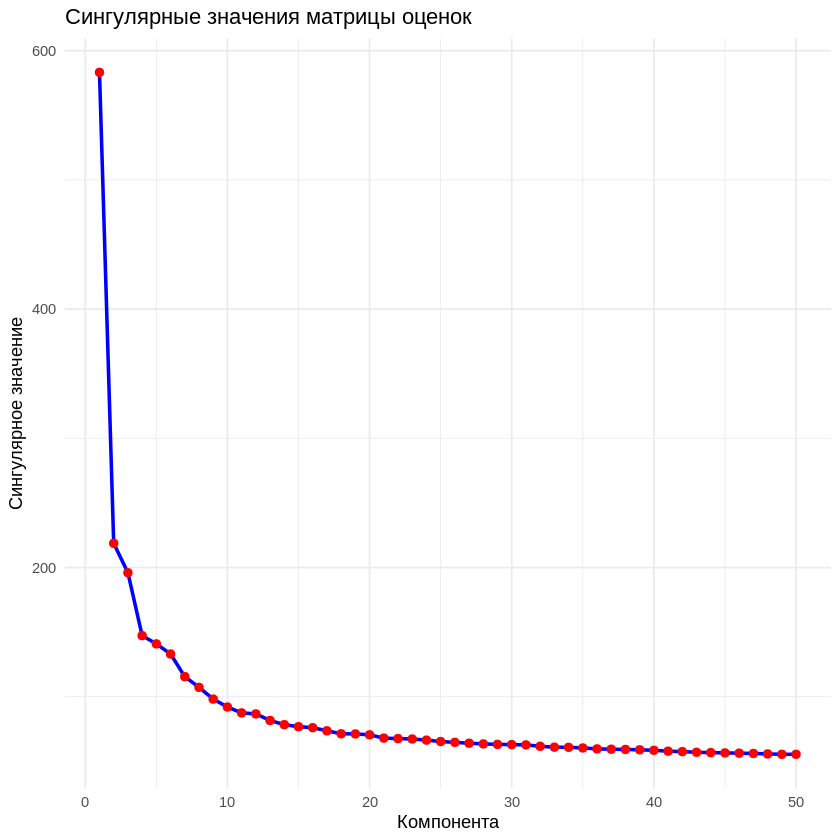

In [12]:
# АНАЛИЗ ЛАТЕНТНЫХ ПРЕДСТАВЛЕНИЙ
cat("\n=== АНАЛИЗ ЛАТЕНТНЫХ ПРЕДСТАВЛЕНИЙ ===\n")

# Анализ сингулярных значений (для классического SVD)
cat("Анализ сингулярных значений:\n")
train_matrix <- as(getData(eval_sets, "train"), "matrix")
train_matrix[is.na(train_matrix)] <- 0

# Вычисление SVD
svd_decomp <- svd(train_matrix)
singular_values <- svd_decomp$d

# Визуализация сингулярных значений
svd_plot_data <- data.frame(
  component = 1:length(singular_values),
  value = singular_values
)

ggplot(svd_plot_data[1:50, ], aes(x = component, y = value)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 2) +
  labs(title = "Сингулярные значения матрицы оценок",
       x = "Компонента", y = "Сингулярное значение") +
  theme_minimal()

# Объясненная дисперсия
explained_variance <- cumsum(singular_values^2) / sum(singular_values^2)
cat("Объясненная дисперсия первыми 10 компонентами:", round(explained_variance[10], 4), "\n")
cat("Объясненная дисперсия первыми 20 компонентами:", round(explained_variance[20], 4), "\n")
cat("Объясненная дисперсия первыми 50 компонентами:", round(explained_variance[50], 4), "\n")

cat("\n=== АНАЛИЗ ЗАВЕРШЕН ===\n")
cat("Лучшая модель:", comparison$Модель[which.min(comparison$RMSE)], "\n")
cat("Лучший RMSE:", min(comparison$RMSE), "\n")

# Сохранение результатов
results <- list(
  svd_model = svd_model,
  mf_model = mf_result,
  kernel_model = kernel_result,
  comparison = comparison
)

saveRDS(results, "matrix_factorization_results.rds")
cat("Результаты сохранены в 'matrix_factorization_results.rds'\n")